Get data.
try multiple clustering algorithms and pplot the profiles

In [1]:
import pandas, seaborn, numpy, pyensembl, scipy, os

import sklearn, sklearn.cluster
import statsmodels, statsmodels.stats, statsmodels.stats.multitest

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(8, 4), 'axes.labelsize':20})

# 0. user-defined variables

In [2]:
up_file = '~/gd15/hi/research/osteo/results/up_and_down_DEGs/up.csv'
overall_file = '~/gd15/hi/research/osteo/results/up_and_down_DEGs/all_zscore.csv'
dorothea_regulons_dir = '/home/adrian/databases/dorothea/regulons/'

days = [3, 6, 9, 16, 28]

# 1. read data

## 1.1. read expression data

In [3]:
deg_expression = pandas.read_csv(up_file, index_col=0)

print(deg_expression.shape)
deg_expression.head()

(571, 5)


,Day_3,Day_6,Day_9,Day_16,Day_28
ENSG00000000971,-1.664697,0.042064,0.891593,-0.397653,1.128693
ENSG00000001561,-1.066237,-0.413406,-0.413406,0.016602,1.876447
ENSG00000003436,-1.422526,0.188673,-0.614408,0.270184,1.578077
ENSG00000003989,-1.387161,-0.461381,0.080165,0.080165,1.688212
ENSG00000004799,-1.363715,-0.278375,-0.542687,0.655548,1.529228


In [ ]:
overall_expression = pandas.read_csv(overall_file, index_col=0)

print(overall_expression.shape)
overall_expression.head()

## 1.2. read TF-gene interactions

In [4]:
regulons = {}
regulon_files = os.listdir(dorothea_regulons_dir)
for file in regulon_files:
    TF_name = file.split('.txt')[0]
    df = pandas.read_csv(dorothea_regulons_dir+file, sep='\t', header=None, names=['target'])
    targets = df['target'].to_list()
    regulons[TF_name] = targets

# 2. format data

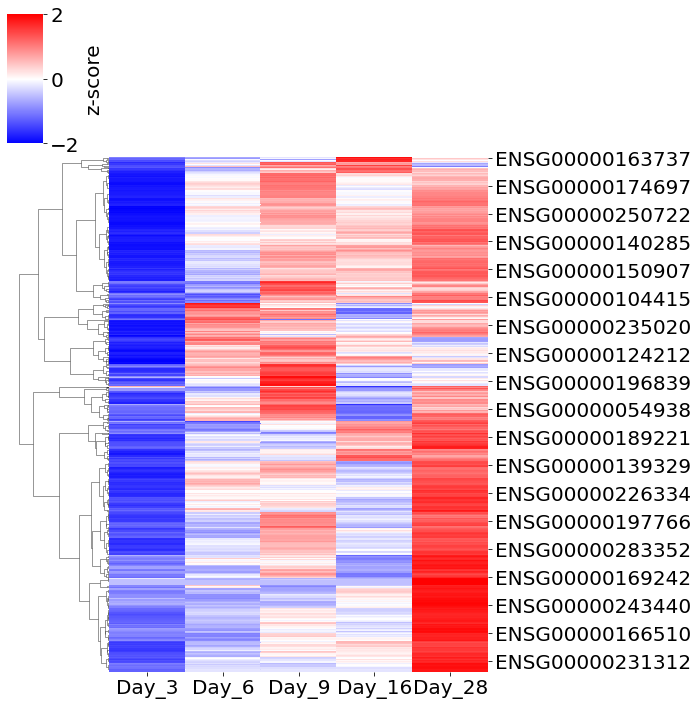

In [5]:
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(deg_expression, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

In [6]:
x = deg_expression.to_numpy()
x

array([[-1.66469709,  0.04206426,  0.89159335, -0.39765329,  1.12869276],
       [-1.06623701, -0.41340623, -0.41340623,  0.01660241,  1.87644706],
       [-1.42252553,  0.18867304, -0.61440847,  0.27018417,  1.57807679],
       ...,
       [-1.72590115, -0.13345424,  0.99640482, -0.13345424,  0.99640482],
       [-1.91030176,  0.80864717,  0.80864717,  0.14650371,  0.14650371],
       [-1.56690258, -0.25444867,  0.6767522 , -0.25444867,  1.39904771]])

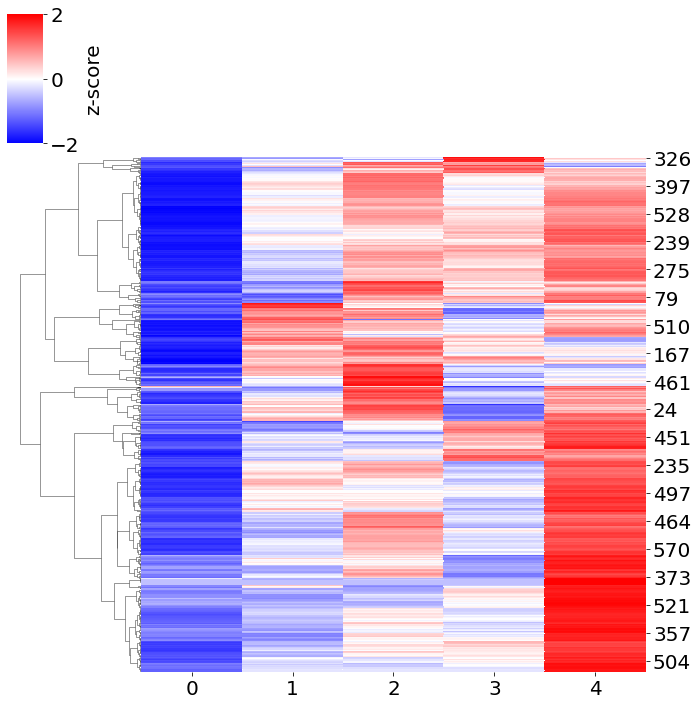

In [7]:
seaborn.clustermap(x, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

# 3. define partition range

In [8]:
number_elements = deg_expression.shape[0]
fine = int(number_elements/5)
coarse = int(number_elements/20)
print(coarse, fine)
k_range = range(coarse, fine+1)

28 114


# 4. clustering

In [9]:
p_ss = []; p_khi = []; p_dbi = []
for k in k_range:

    partition = sklearn.cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='complete').fit(x)
    labels = partition.labels_

    ss = sklearn.metrics.silhouette_score(x, labels, metric='cosine')
    khi = sklearn.metrics.calinski_harabasz_score(x, labels)
    dbi = sklearn.metrics.davies_bouldin_score(x, labels)

    p_ss.append(ss)
    p_khi.append(khi)
    p_dbi.append(dbi)

In [10]:
# need to do with K means and all other methods present in sklearn that are inductive (?)

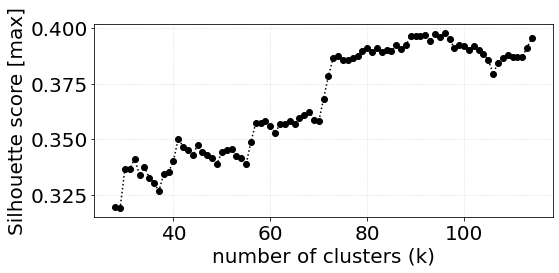

In [11]:
matplotlib.pyplot.plot(k_range, p_ss, 'ok')
matplotlib.pyplot.plot(k_range, p_ss, ':', color='black')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Silhouette score [max]')
matplotlib.pyplot.tight_layout()

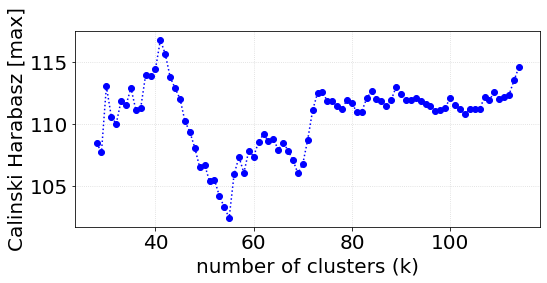

In [12]:
matplotlib.pyplot.plot(k_range, p_khi, 'ob')
matplotlib.pyplot.plot(k_range, p_khi, ':', color='blue')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Calinski Harabasz [max]')
matplotlib.pyplot.tight_layout()

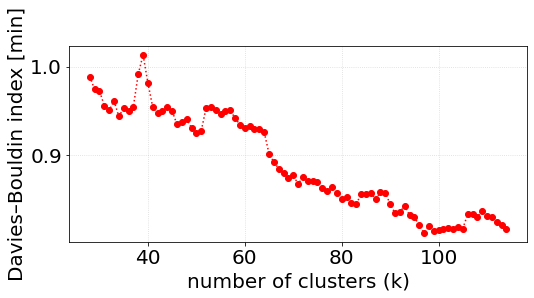

In [13]:
matplotlib.pyplot.plot(k_range, p_dbi, 'or')
matplotlib.pyplot.plot(k_range, p_dbi, ':', color='red')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Davies–Bouldin index [min]')
matplotlib.pyplot.tight_layout()

In [14]:
# visualize 41, otherwise, if not tight enough another much larger like 100

# 5. visualization

In [15]:
# try enrichments in >= 2. Try with k=41 and k=100 

## 5.1. annotation

In [16]:
annotation = pyensembl.EnsemblRelease(86) # better matching than version 100
annotation

EnsemblRelease(release=86, species='homo_sapiens')

In [17]:
# 12 missing for annotation 75
# 9 missing for annotation 86
# 11 missing for annotation 100
# 11 missing for annotation 102
up_genes = deg_expression.index.to_list()
rosetta_up_genes = {}

missing = 0
for ensembl in up_genes:
    try:
        gene_name = annotation.gene_by_id(ensembl).gene_name
        rosetta_up_genes[ensembl] = gene_name
    except:
        missing = missing + 1
        print('Missing #{}. {} not found'.format(missing, ensembl))

Missing #1. ENSG00000263238 not found
Missing #2. ENSG00000273707 not found
Missing #3. ENSG00000274619 not found
Missing #4. ENSG00000275482 not found
Missing #5. ENSG00000278843 not found
Missing #6. ENSG00000282147 not found
Missing #7. ENSG00000282854 not found
Missing #8. ENSG00000283009 not found
Missing #9. ENSG00000283106 not found


## 5.2. enrichment

In [18]:
# define M, the number of target genes in Dorothea regulons
all_targets = []
for TF in regulons:
    for element in regulons[TF]:
        all_targets.append(element)
M = len(list(set(all_targets)))
print('found {} targets'.format(M))

found 20295 targets


In [19]:
k = 41
partition = sklearn.cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='complete').fit(x)
labels = partition.labels_

In [20]:
k = 10
for label in range(k):
    indices = numpy.where(labels == label)[0]
    print('\nCluster c{} with {} gene indices: {}'.format(label, len(indices), indices))
    cluster = deg_expression.iloc[indices, :]
    
    ###
    ### plotting
    ###
    for gene in cluster.index:
        matplotlib.pyplot.plot(days, cluster.loc[gene, :], 'o-')
    matplotlib.pyplot.xlabel('Time (day)')
    matplotlib.pyplot.ylabel('zscore')
    matplotlib.pyplot.grid(alpha=0.5, ls=':')
    matplotlib.pyplot.ylim([-2, 2])
    matplotlib.pyplot.xlim(([0, 29]))
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    
    ###
    ### convert cluster ENSEMBL ids into gene names
    ###
    cluster_ensembl_ids = deg_expression.index[indices]
    cluster_gene_names = []
    for ensembl in cluster_ensembl_ids:
        try:
            gene_name = rosetta_up_genes[ensembl]
            cluster_gene_names.append(gene_name)
        except:
            print('ENSEMBL ID {} lost.'.format(ensembl))
    print('{}/{} genes recovered.'.format(len(cluster_gene_names), len(cluster_ensembl_ids)))
    
    
    ###
    ### enrichment
    ###
    
    # define N, the size of the regulon
    N = len(cluster_gene_names)
    
    # get all TFs regulating each target gene
    putative_TFs = []
    for gene_name in cluster_gene_names:
        for TF in regulons:
            if gene_name in regulons[TF]:
                putative_TFs.append(TF)
    putative_regulators = list(set(putative_TFs))
    print('all possible regulators of this cluster:', putative_regulators)
    
    # hypergeometric test for putative regulators
    p_values_uncorrected = []
    hits_tracker = [] # stores tuples of number of targets and hits
    for putative_regulator in putative_regulators:
        
        # define n, the number of targets of that particular TF in Dorothea
        global_TF_targets = regulons[putative_regulator]
        n = len(global_TF_targets)
        #print(putative_regulator, n)
        
        # define x, the number of DETs that are targets of that particular TF
        intersect = list(set(cluster_gene_names) & set(global_TF_targets))
        x = len(intersect)
        
        # make sure that the regulon has at least two target genes for a given TF, otherwise, don't waste hypothesis correction
        if x >= 2:
            #print('\t {}/{}'.format(x, n))
            pvalue = scipy.stats.hypergeom.sf(x-1, M, n, N)
            p_values_uncorrected.append(pvalue)
            
            tracking_tuple = (putative_regulator, n, M, x, N)
            hits_tracker.append(tracking_tuple)
            
    # multiple correction for all putative regulators of this cluster: Benjamini–Hochberg correction
    alternative, corrected_p_values = statsmodels.stats.multitest.fdrcorrection(p_values_uncorrected, alpha=0.1)
    for i in range(len(alternative)):
        if alternative[i] == True:
            print('HIT', hits_tracker[i], p_values_uncorrected[i], corrected_p_values[i])


Cluster c0 with 7 gene indices: [ 64 197 240 299 307 347 509]
7/7 genes recovered.
all possible regulators of this cluster: ['FOXF2', 'GLI4', 'EMX2', 'SOX3', 'ZBTB7C', 'ZNF777', 'CREB3L4', 'ZNF775', 'CREB3L2', 'TFEC', 'PATZ1', 'NR1H4', 'ZFPM1', 'ZNF771', 'ZNF589', 'SPIC', 'ZNF554', 'VENTX', 'ZBTB4', 'THAP8', 'ZNF672', 'ZNF469', 'RAX', 'KLF11', 'TFEB', 'ZNF575', 'ATF5', 'SALL2', 'NR3C2', 'ZNF319', 'ZNF680', 'ZBTB6', 'HOXA9', 'FOXC1', 'ZNF768', 'ZNF219', 'ZXDA', 'KLF14', 'ZNF547', 'ZNF281', 'ZNF549', 'ZNF296', 'HOXA5', 'HLX', 'ETV2', 'ZNF835', 'RFX4', 'KLF10', 'OSR2', 'CASZ1', 'KLF12', 'ZNF358', 'OSR1', 'ZNF837', 'ASCL2', 'ZNF423', 'ZNF414', 'ZNF618', 'TP53', 'ZNF853', 'ELK3', 'HOXA3', 'BNC2', 'TSHZ1', 'NFIX', 'TRERF1', 'CXXC4', 'ZBTB17', 'HOXA2', 'UBP1', 'TBX6', 'NR2E3', 'MEIS3', 'ZXDB', 'NEUROG1', 'ERF', 'ZNF48', 'ZNF501', 'SMAD9', 'ZHX2', 'FOXS1', 'HOXB4', 'PBX1', 'TSHZ3', 'ATF6B', 'PAX1', 'SOX15', 'HOXC9', 'GATA2', 'GLIS2', 'MEOX2', 'ZNF205', 'SCRT1', 'RFX3', 'BHLHA15', 'ZNF524', 'G

Cluster c5 with 13 gene indices: [ 34  55 157 221 236 243 274 382 396 446 488 500 507]
13/13 genes recovered.
all possible regulators of this cluster: ['SOX18', 'ZNF329', 'HAND2', 'ZNF337', 'FOXF2', 'NR2E1', 'HOXC10', 'KLF8', 'ZNF70', 'NFIB', 'SOX7', 'OTX1', 'ZNF354C', 'TCF7L1', 'ZNF521', 'PLAG1', 'OLIG2', 'SOX17', 'HEYL', 'ZNF750', 'GLI4', 'EMX2', 'LMX1A', 'HEY2', 'ZBTB7C', 'NR4A2', 'CREB3L4', 'ZNF532', 'BATF2', 'PRRX1', 'FOXO4', 'ZNF775', 'CREB3L2', 'OVOL2', 'TFEC', 'ZFP82', 'BARHL2', 'GLIS1', 'MYCL', 'MAF', 'PCGF2', 'HSF4', 'IRF1', 'HOXA11', 'PRRX2', 'SATB2', 'ZBTB7B', 'PATZ1', 'MNX1', 'ZNF71', 'ZNF133', 'MTF1', 'RBPJ', 'ZNF333', 'ZBTB14', 'MYF6', 'SOX8', 'SALL1', 'MEF2D', 'FOXD2', 'KLF15', 'BCL11B', 'ZIC3', 'PKNOX2', 'HES2', 'ZNF76', 'HOXC12', 'ZNF554', 'OVOL1', 'SNAI3', 'ZNF500', 'VENTX', 'FOXO1', 'ZBTB4', 'NFAT5', 'RORC', 'ZNF418', 'ZNF436', 'SP100', 'LIN54', 'CXXC1', 'PEG3', 'NFIL3', 'PURG', 'ADNP', 'HLF', 'ZNF575', 'TBX19', 'ZNF211', 'SALL2', 'ZSCAN30', 'FOXI1', 'TCFL5', 'THRA'

all possible regulators of this cluster: ['SOX18', 'FOXP1', 'ZNF586', 'TCF7L1', 'ZNF521', 'SOX17', 'FOS', 'ZNF750', 'EMX2', 'LMX1A', 'SOX3', 'SOX1', 'SALL4', 'GLIS1', 'BARHL2', 'HSF4', 'PRRX2', 'PATZ1', 'TBX1', 'TBX3', 'MTF1', 'ZFPM1', 'NKX3-2', 'ZBTB14', 'NME2', 'MYF6', 'SOX8', 'ZNF331', 'KLF15', 'FOXD2', 'NKX2-2', 'ESRRB', 'HIVEP2', 'DMRTC2', 'FEZF2', 'ZNF250', 'ZNF276', 'ZBTB4', 'NFAT5', 'ZNF469', 'SP100', 'PURG', 'MKX', 'HOXB8', 'TBX19', 'ESRRG', 'SALL2', 'HOXD3', 'FOXI1', 'ZNF92', 'TBX5', 'ZBTB47', 'MEIS1', 'PAX2', 'ZNF207', 'ZNF496', 'ZNF768', 'NHLH1', 'SIX3', 'ZNF219', 'ZFHX4', 'ZNF281', 'TBX2', 'MAZ', 'NR1D1', 'TEAD3', 'HLX', 'MSX1', 'LHX6', 'ETV5', 'JDP2', 'NR2F1', 'MECOM', 'NR6A1', 'LHX4', 'OSR2', 'ZNF467', 'ST18', 'SP110', 'KLF12', 'GTF2B', 'ZBTB7A', 'SP140', 'FOXO6', 'ZNF322', 'SCX', 'SOX9', 'HOXB2', 'HOXC13', 'ZNF358', 'OSR1', 'RORB', 'TBX15', 'SP140L', 'ETV7', 'PLAGL1', 'THRB', 'TSHZ2', 'ZNF423', 'ARNT2', 'LMX1B', 'IRX6', 'HMX2', 'ZNF853', 'MESP1', 'DMRTB1', 'ZNF362', 'TC

# 6. informative cell

In [21]:
import scipy

# M is the population size
# n is the number of successes in the population 
# N is the sample size (previously n)
# x is still the number of drawn “successes”

# M is the total number of targets in Dorothea
# n is the number of targets of a particular TF in Dorothea
# N is the size of DETs
# x is the number of DETs that are targets of a particular TF

M = 20000
n = 200

N = 1000
x = 20 # 10 would be the same ratio


print('p-value <= ' + str(x) + ': ' + str(scipy.stats.hypergeom.cdf(x, M, n, N)))
print('p-value >= ' + str(x)  + ': ' + str(scipy.stats.hypergeom.sf(x-1, M, n, N)))

p-value <= 20: 0.9989104333089479
p-value >= 20: 0.0025301883214874205
